In [ ]:
!pip3 install torch torchvision
!pip3 install split-folders tqdm
!pip3 install opencv-python
!pip3 install Pillow

In [ ]:
# mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# copy zip file from drive
!cp /content/drive/MyDrive/DLFHC/CXR.zip ./CXR_copy.zip

In [ ]:
import os
import random
import torch
import numpy as np
import torch.nn.functional as F
import math   
import torchvision
import matplotlib.pyplot as plt
import splitfolders
import pandas as pd
import cv2
from sklearn import preprocessing
from torch import nn
from torchvision import datasets, transforms, models
from sklearn.metrics import precision_recall_fscore_support, accuracy_score, roc_auc_score
from PIL import Image

# set seed
seed = 21
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
os.environ["PYTHONHASHSEED"] = str(seed)

In [ ]:
# use GPU if available
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [ ]:
def gray_sobel_transform(img, sobel_kernel = 3):
    # from: https://www.programcreek.com/python/?project_name=PacktPublishing%2FOpenCV-3-x-with-Python-By-Example via https://www.programcreek.com/python/example/85270/cv2.CV_64F 
    
    # usually grayscaled, but this cannot be turned back
    grayscaled = 255 * np.array(img).astype('uint8') # img # cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # for defining orientations
    # use cv2.CV_64F for kernel
    # apply both directions
    sobel_x = cv2.Sobel(grayscaled,cv2.CV_32F, 1, 0, ksize= sobel_kernel) 
 
    sobel_y = cv2.Sobel(grayscaled,cv2.CV_32F, 0, 1, ksize= sobel_kernel) 

    # scaled
    abs_sobel_x = cv2.convertScaleAbs(sobel_x) 
    abs_sobel_y = cv2.convertScaleAbs(sobel_y) 

    # Weighted sums to combine x and y
    weighted_image = cv2.addWeighted(abs_sobel_x, 0.5, abs_sobel_y, 0.5, 0)
    

    #ALTERNATIVE EDGE FINDING: LAPLACIAN (basically subtract the gaussian blur)
    # weighted_image = cv2.Laplacian(grayscaled,cv2.CV_64F)


    # and then return the image
    return Image.fromarray(weighted_image)

In [ ]:
def split_data(isBinary):
  # Unzip data and set input and output paths
  !unzip -q ./CXR_copy.zip

  if isBinary:
    print('removing pneumonia images')
    !rm -rf ./CXR/pneumonia_CXR

  # test validate split
  splitfolders.ratio('./CXR', output='./splitCXR', seed=seed, ratio=(.7, .2, .1), group_prefix=None)

In [ ]:
def clean_up():
  !rm -rf ./CXR ./splitCXR

In [ ]:
def get_transform(transformation):
  # No augmentation on test data
  test_transform = transforms.Compose([
                                transforms.Resize((224,224)),
                                transforms.ToTensor(), 
                                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                                ])
  if transformation == 'Sobel':
    # From https://discuss.pytorch.org/t/how-to-use-generic-transforms-for-the-following-preprocessing-step/50658
    train_transform = transforms.Compose([
                                  transforms.Resize((224,224)),
                                  transforms.Lambda(gray_sobel_transform), # Sobel!
                                  transforms.ToTensor(),                          
                                  transforms.Normalize(mean = (0,)*3, std = (0.1)*3)                                
                                ])
  elif transformation == 'Gaussian':
    train_transform = transforms.Compose([
                                  transforms.Resize((224,224)),
                                  transforms.ToTensor(), 
                                  transforms.GaussianBlur(11, sigma=(0.1, 2.0)),
                                  transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                                ])
  elif transformation == 'Random Perspective & Vertical Flip':
    train_transform = transforms.Compose([transforms.Resize((224,224)),
                                  transforms.RandomVerticalFlip(),
                                  transforms.RandomPerspective(),
                                  transforms.ToTensor(),
                                  transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                               ])
  elif transformation == 'Unaugmented':
    train_transform = test_transform
  else:
    raise Exception('Invalid tranformation')
  return train_transform, test_transform

In [ ]:
def get_data_loaders(transformation):
  train_transform, test_transform = get_transform(transformation)

  train_data = datasets.ImageFolder('./splitCXR/train', transform=train_transform)
  val_data = datasets.ImageFolder('./splitCXR/val', transform=test_transform)
  test_data = datasets.ImageFolder('./splitCXR/test', transform=test_transform)

  # Use subset
  # train_size = 200
  # train_data = torch.utils.data.Subset(train_data, np.random.choice(len(train_data), train_size, replace=False))
  # val_data = torch.utils.data.Subset(val_data, np.random.choice(len(val_data), math.floor(train_size * .2), replace=False))
  # test_data = torch.utils.data.Subset(test_data, np.random.choice(len(test_data),  math.floor(train_size * .1), replace=False))

  print('Number of training images: {:.0f}'.format(len(train_data)))
  print('Number of validation images: {:.0f}'.format(len(val_data)))
  print('Number of test images: {:.0f}'.format(len(test_data)))

  training_loader = torch.utils.data.DataLoader(dataset=train_data, batch_size=32, shuffle=True)
  validation_loader = torch.utils.data.DataLoader(dataset=val_data, batch_size=32, shuffle=False)
  test_loader = torch.utils.data.DataLoader(dataset=test_data, batch_size=32, shuffle=False)

  return training_loader, validation_loader, test_loader

In [ ]:
def imshow(img, title):
    npimg = img.numpy()
    plt.figure(figsize=(15, 7))
    plt.axis('off')
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.title(title)
    plt.show()

def show_batch_images(dataloader):
    images, labels = next(iter(dataloader))
    img = torchvision.utils.make_grid(images, padding=25)
    imshow(img, title=None)

In [ ]:
def train(model, epochs, lr, training_loader, validation_loader):
  criterion = nn.CrossEntropyLoss()
  optimizer = torch.optim.Adam(model.parameters(), lr = lr)

  running_loss_history = []
  running_correct_history = []

  val_running_loss_history = []
  val_running_corrects_history = []
  for i in range(epochs):
    running_loss = 0.0
    running_correct = 0.0
    val_running_loss = 0.0
    val_running_corrects = 0.0
    for inputs, labels in training_loader:
      inputs = inputs.to(device)
      labels = labels.to(device)
      outputs = model.forward(inputs)
      loss = criterion(outputs, labels)

      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      _, preds = torch.max(outputs,1)
      running_correct += torch.sum(preds == labels.data)
      running_loss += loss.item()
    else:
      with torch.no_grad():
        for val_inputs, val_labels in validation_loader:
          val_inputs = val_inputs.to(device)
          val_labels = val_labels.to(device)

          val_outputs = model.forward(val_inputs)
          val_loss = criterion(val_outputs, val_labels)

          _, val_preds = torch.max(val_outputs,1)
          val_running_corrects += torch.sum(val_preds == val_labels.data)
          val_running_loss += val_loss.item()

      epoch_loss = running_loss / len(training_loader.dataset)
      epoch_accuracy = running_correct.float() / len(training_loader.dataset)
      running_loss_history.append(epoch_loss)
      running_correct_history.append(epoch_accuracy)

      val_epoch_loss = val_running_loss / len(validation_loader.dataset)
      val_epoch_accuracy = val_running_corrects.float() / len(validation_loader.dataset)
      val_running_loss_history.append(val_epoch_loss)
      val_running_corrects_history.append(val_epoch_accuracy)

      print('epoch: ', (i+1))
      print('training loss = {:.4f}, accuracy {:.4f}'.format(epoch_loss, epoch_accuracy.item()))
      print('validation loss = {:.4f}, validation accuracy {:.4f}'.format(val_epoch_loss, val_epoch_accuracy.item()))
  return (running_loss_history,running_correct_history,val_running_loss_history,val_running_corrects_history)

In [ ]:
# Calculate roc_auc scores for multiclass data
# From https://medium.com/@plog397/auc-roc-curve-scoring-function-for-multi-class-classification-9822871a6659
def multiclass_roc_auc_score(y_test, y_pred, average="macro"):
  lb = preprocessing.LabelBinarizer()
  lb.fit(y_test)
  y_test = lb.transform(y_test)
  y_pred = lb.transform(y_pred)

  return roc_auc_score(y_test, y_pred, average=average)

In [ ]:
def eval(model, test_loader):
    y_pred = torch.LongTensor()
    y_true = torch.LongTensor()
    model.eval()
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        y_prob = model(inputs)
        _, preds = torch.max(y_prob,1)

        y_pred = torch.cat((y_pred,  preds.detach().to('cpu')), dim=0)
        y_true = torch.cat((y_true, labels.detach().to('cpu')), dim=0)
    
    p, r, f, _ = precision_recall_fscore_support(y_true, y_pred, average='macro')
    a = accuracy_score(y_true, y_pred)
    roc_auc = multiclass_roc_auc_score(y_true, y_pred)

    result_df = pd.DataFrame({'Accuracy':[a],'Precision':[p],'Recall':[r],'F1 Score':[f], 'ROC AUC':[roc_auc]})
    return result_df

In [ ]:
# Functions for visualizing loss and accuracy histories while training
def print_loss_histories(validation_loss_histories, tranformation, chart_label):
  for key in validation_loss_histories:
    plt.plot(validation_loss_histories[key], label=key)
    plt.legend()
    plt.title(chart_label + tranformation + " Validation Loss History")
  plt.show()

def print_accuracy_histories(validation_accuracy_histories, tranformation, chart_label):
  for key in validation_accuracy_histories:
    plt.plot(validation_accuracy_histories[key], label=key)
    plt.legend()
    plt.title(chart_label + tranformation + " Validation Accuracy History")
  plt.show()

In [ ]:
def get_models(classes):
  # ResNet
  resNetModel = models.resnext101_32x8d(pretrained=True)
  for param in resNetModel.parameters():
    param.requires_grad = False

  res_inputs = resNetModel.fc.in_features
  resNetModel.fc = nn.Linear(res_inputs, len(classes))
  resNetModel.to(device)

  # AlexNet
  alexNetModel = models.alexnet(pretrained=True)
  for param in alexNetModel.features.parameters():
    param.requires_grad = False

  alex_in_features = alexNetModel.classifier[6].in_features 
  alexNetModel.classifier[6] = nn.Linear(in_features=alex_in_features, out_features=len(classes))
  alexNetModel.to(device)

  # DenseNet
  denseNetModel = models.densenet201(pretrained=True)
  for param in denseNetModel.features.parameters():
    param.requires_grad = False

  dense_last_input = denseNetModel.classifier.in_features
  denseNetModel.classifier = nn.Linear(in_features=dense_last_input, out_features=len(classes))
  denseNetModel.to(device)

  # VGG
  vggModel = models.vgg19(pretrained=True)
  for param in vggModel.features.parameters():
    param.requires_grad = False
  vgg_last_layer_input = vggModel.classifier[6].in_features
  vgg_new_layer = nn.Linear(in_features=vgg_last_layer_input, out_features=len(classes))
  vggModel.classifier[6] = vgg_new_layer
  vggModel.to(device)

  return [
          { 
            'name': 'ResNet',
            'model': resNetModel
          }, 
          { 
            'name': 'AlexNet',
            'model':alexNetModel
          }, 
          {
            'name': 'DesnseNet',
            'model': denseNetModel
          }, 
          { 
            'name': 'VGG',
            'model': vggModel
          }
        ]

In [ ]:
def run_experiment(transformation, classes):
  validation_loss_histories = {}
  validation_accuracy_histories = {}
  eval_results = []

  epochs = 8
  lr = 0.0001

  models = get_models(classes)
  training_loader, validation_loader, test_loader = get_data_loaders(transformation)

  # View one image batch
  show_batch_images(training_loader)

  for model in models:
    print('\n#################### Training ' + model['name'] + ' ####################')

    running_loss_history,running_correct_history,val_running_loss_history,val_running_corrects_history = train(model['model'], epochs, lr, training_loader, validation_loader)
    validation_loss_histories[model['name']] = val_running_loss_history
    validation_accuracy_histories[model['name']] = val_running_corrects_history

    eval_results.append({ 
        'name': model['name'],
        'results': eval(model['model'], test_loader)
    })

  for result in eval_results:
    print('\n#################### Test Results ' + result['name'] + ' ####################')
    print(result['results'])
    print('##########################################################\n')

  chart_label = 'Binary ' if len(classes) == 2 else 'Multi-class '
  print_loss_histories(validation_loss_histories, transformation, chart_label)
  print_accuracy_histories(validation_accuracy_histories, transformation, chart_label)

  # Can retun models for reuse
  # return models

In [ ]:
def run_multi_class():
  isBinary = False
  split_data(isBinary)
  classes = ('COVID', 'Normal', 'Pneumonia')
  run_experiment('Sobel', classes)
  run_experiment('Gaussian', classes)
  run_experiment('Random Perspective & Vertical Flip', classes)
  run_experiment('Unaugmented', classes)
  clean_up()


def run_binary():
  isBinary = True
  split_data(isBinary)
  classes = ('COVID', 'Normal')
  run_experiment('Sobel', classes)
  run_experiment('Gaussian', classes)
  run_experiment('Random Perspective & Vertical Flip', classes)
  run_experiment('Unaugmented', classes)
  clean_up()

Copying files: 18691 files [00:06, 3029.45 files/s]
Downloading: "https://download.pytorch.org/models/resnext101_32x8d-8ba56ff5.pth" to /root/.cache/torch/hub/checkpoints/resnext101_32x8d-8ba56ff5.pth


Downloading: "https://download.pytorch.org/models/alexnet-owt-4df8aa71.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-4df8aa71.pth


Downloading: "https://download.pytorch.org/models/densenet201-c1103571.pth" to /root/.cache/torch/hub/checkpoints/densenet201-c1103571.pth


Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth



Number of training images: 13082
Number of validation images: 3738
Number of test images: 1871


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


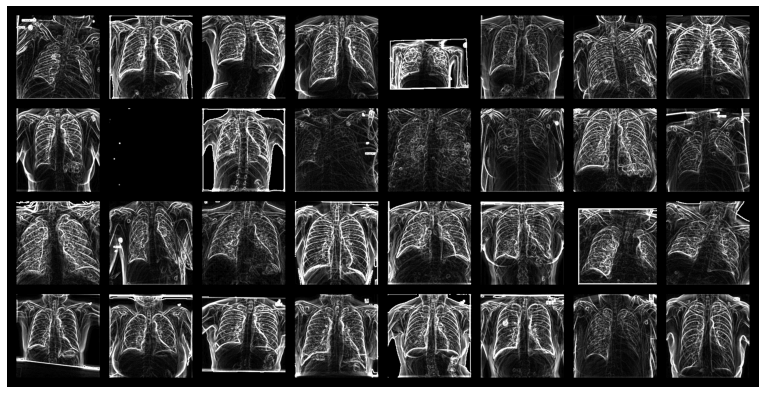


#################### Training ResNet ####################
epoch:  1
training loss = 0.0225, accuracy 0.7237
validation loss = 0.0355, validation accuracy 0.4810
epoch:  2
training loss = 0.0173, accuracy 0.7992
validation loss = 0.0373, validation accuracy 0.4529
epoch:  3
training loss = 0.0160, accuracy 0.8097
validation loss = 0.0385, validation accuracy 0.4797
epoch:  4
training loss = 0.0151, accuracy 0.8219
validation loss = 0.0392, validation accuracy 0.4583
epoch:  5
training loss = 0.0146, accuracy 0.8249
validation loss = 0.0401, validation accuracy 0.4462
epoch:  6
training loss = 0.0142, accuracy 0.8308
validation loss = 0.0408, validation accuracy 0.4746
epoch:  7
training loss = 0.0138, accuracy 0.8377
validation loss = 0.0408, validation accuracy 0.4334
epoch:  8
training loss = 0.0138, accuracy 0.8363
validation loss = 0.0410, validation accuracy 0.4476

#################### Training AlexNet ####################
epoch:  1
training loss = 0.0136, accuracy 0.8378
validat

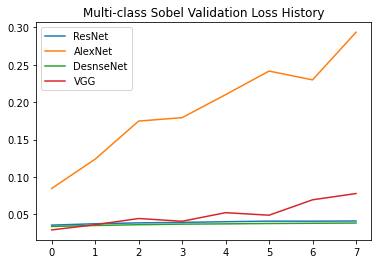

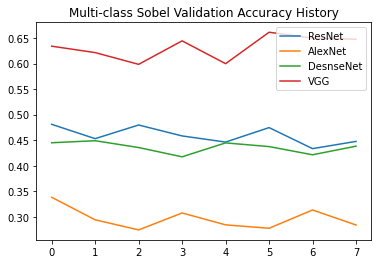

Number of training images: 13082
Number of validation images: 3738
Number of test images: 1871


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


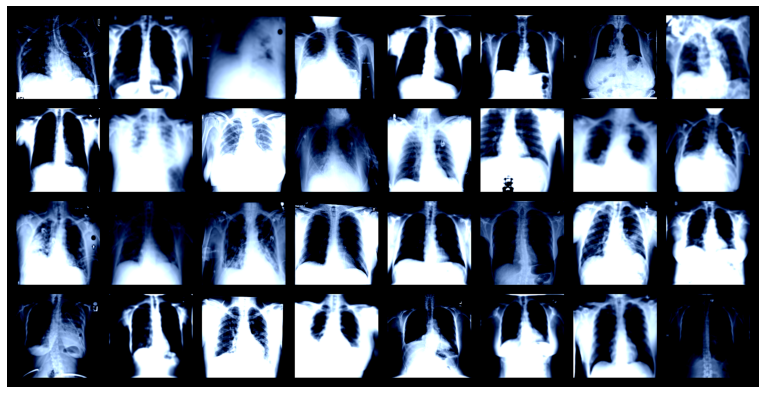


#################### Training ResNet ####################
epoch:  1
training loss = 0.0219, accuracy 0.7352
validation loss = 0.0370, validation accuracy 0.4826
epoch:  2
training loss = 0.0168, accuracy 0.8058
validation loss = 0.0391, validation accuracy 0.4946
epoch:  3
training loss = 0.0153, accuracy 0.8199
validation loss = 0.0403, validation accuracy 0.4901
epoch:  4
training loss = 0.0146, accuracy 0.8305
validation loss = 0.0413, validation accuracy 0.4848
epoch:  5
training loss = 0.0141, accuracy 0.8313
validation loss = 0.0418, validation accuracy 0.4834
epoch:  6
training loss = 0.0138, accuracy 0.8375
validation loss = 0.0424, validation accuracy 0.4671
epoch:  7
training loss = 0.0135, accuracy 0.8424
validation loss = 0.0426, validation accuracy 0.4719
epoch:  8
training loss = 0.0132, accuracy 0.8455
validation loss = 0.0431, validation accuracy 0.4781

#################### Training AlexNet ####################
epoch:  1
training loss = 0.0122, accuracy 0.8510
validat

In [ ]:
run_multi_class()

In [ ]:
run_binary()